Team Members:\
1- MARIM AMER\
2- MAWADA AMER\
3- YOUMNA ALSAYED

In [ ]:
!pip install flappy-bird-gym
!pip install numpy tensorflow gym
!pip install Box2D

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Mawada\Anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Mawada\\AppData\\Local\\Temp\\pip-install-pfd3ft4u\\box2d_a20cb1c6173e46f19e1ef79a5c418d0e\\setup.py'"'"'; __file__='"'"'C:\\Users\\Mawada\\AppData\\Local\\Temp\\pip-install-pfd3ft4u\\box2d_a20cb1c6173e46f19e1ef79a5c418d0e\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Mawada\AppData\Local\Temp\pip-wheel-kdmhbfpk'
       cwd: C:\Users\Mawada\AppData\Local\Temp\pip-install-pfd3ft4u\box2d_a20cb1c6173e46f19e1ef79a5c418d0e\
  Complete output (16 lines):
  Using setuptools (version 58.0.4).
  running bdist_wheel
  running build
  running build_py
  creating build
  cr


  Using cached Box2D-2.3.2.tar.gz (427 kB)
  Running setup.py clean for Box2D
Failed to build Box2D
    Running setup.py install for Box2D: started
    Running setup.py install for Box2D: finished with status 'error'


In [ ]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple


In [ ]:
import flappy_bird_gym
env = flappy_bird_gym.make("FlappyBird-v0")
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (2,)
Number of actions:  2


In [ ]:
class Create_model(nn.Module):
    """Create NN (Policy) Model"""

    def __init__(self, num_state, num_action, seed=1000):
        """
            num_state: Number of state
            num_action: Number of action
            seed: Generate random numbers
        """

        super(Create_model, self).__init__()
        self.seed = torch.manual_seed(seed)  
        self.fc1 = nn.Linear(num_state, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, num_action)



        
    def forward(self, state):
        """Create a network state -> action"""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [ ]:
class Experience_memory:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, num_action, size_of_buffer, batch_size, seed=1000):
        """       
            num_action: number of action
            size_of_buffer: maximum size of buffer
            batch_size: size of training batch
            seed: Generate random numbers
        """
        self.num_action = num_action
        self.memory = deque(maxlen=size_of_buffer)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def collect(self, state, action, reward, next_state, done):
        """Append new experience to memory"""
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)
    
    def sample(self):
        """Taking a random sample of memories from a large collection"""
        samples = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([s.state for s in samples if s is not None])).float()
        actions = torch.from_numpy(np.vstack([s.action for s in samples if s is not None])).long()
        rewards = torch.from_numpy(np.vstack([s.reward for s in samples if s is not None])).float()
        next_states = torch.from_numpy(np.vstack([s.next_state for s in samples if s is not None])).float()
        dones = torch.from_numpy(np.vstack([s.done for s in samples if s is not None]).astype(np.uint8)).float()
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of memory."""
        return len(self.memory)

In [ ]:
size_of_buffer = int(100000)  # buffer size
LR = 0.0005                   # learning rate 
UPDATE_EVERY = 5              # how often to update the network
gamma = 0.999                 # discount factor
tau = 0.001                   # for soft update of target parameters
batch_size = 64               # minibatch size

In [ ]:
class DQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, num_state, num_action, seed = 1000):
        """Initialize an Agent object.   
        Params
        ======
            num_state: Number of state
            num_action: Number of action
            seed: Generate random numbers
        """
        self.num_state = num_state
        self.num_action = num_action
        self.seed = random.seed(seed)

        # Create Q-Network
        self.model = Create_model(num_state, num_action, seed)
        self.target_model = Create_model(num_state, num_action, seed)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)

        # Create memory to store experiences
        self.memory = Experience_memory(num_action, size_of_buffer, batch_size, seed)

        # Initialize Time step (to update every specific number of steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save new experience steps in memory
        self.memory.collect(state, action, reward, next_state, done)
        
        # Learn every specific number of time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, gamma)

    def get_action(self, state, epsilon = 1.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state: current state
            epsilon: for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.model.eval()
        with torch.no_grad():
            action_values = self.model(state)
        self.model.train()

        # Selection epsilon greedy action
        if random.random() > epsilon:
            return np.argmax(action_values.data.numpy())
        else:
            return random.choice(np.arange(self.num_action))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences: tuple of (State, Action, Reward, Next state, done)
            gamma: discount factor
        """

        # Get random small batches of tuples from D.
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss

        # Extract the following estimated maximum value from the target network.
        q_targets_next = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)

        # Calculate target value
        q_targets = rewards + gamma * q_targets_next * (1 - dones)

        # Calculate expected value from the model
        q_expected = self.model(states).gather(1, actions)
        
        # Calculate the Loss by using Mean squared error
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target model
        self.soft_update(self.model, self.target_model, tau)                     

    def soft_update(self, model, target_model, tau):
        """Update model parameters
        θ_target = τ*θ_model + (1 - τ)*θ_target

        Params
        ======
            model: weights will be copied from
            target_model: weights will be copied to
            tau: interpolation parameter
        """
        for target_param, model_param in zip(target_model.parameters(), model.parameters()):
            target_param.data.copy_(tau*model_param.data + (1.0-tau)*target_param.data)

In [ ]:
def Draw_graph(total_episodes, total_reword_eps10_train, total_TimeSteps_eps10_train, total_reword_eps5_test, total_TimeSteps_eps5_test):
    """ Draw Training and Testing's Rewards and Actions

    Params
    ======
          total_episodes: Total Episodes
          total_reword_eps10_train: list contains all rewards in each episode
          total_TimeSteps_eps10_train: list contains all Time Steps in each episode
          total_reword_eps5_test: list contains all rewards after each 5 episode 
          total_TimeSteps_eps5_test: list contains all Time Steps after each 5 episode

    """

    # ------------------------------------- Training Rewards -------------------------------------
    fig, axs = plt.subplots(2, 2,figsize=(15,15))
    axs[0, 0].plot(total_episodes, total_reword_eps10_train)
    axs[0, 0].set_title('Training Rewards')
    # Highlight the maximum Rewards in Training episodes
    axs[0, 0].hlines(max(total_reword_eps10_train), 0, len(total_episodes), colors = "tab:red", linestyles = "dashed",linewidth=2)
    axs[0, 0].set(xlabel='Episodes', ylabel='Rewards')

    # ------------------------------------ Training Time Steps ------------------------------------
    axs[0, 1].plot(total_episodes, total_TimeSteps_eps10_train, 'tab:orange')
    axs[0, 1].set_title('Training Time Steps')
    # Highlight the minimum Time Steps in Training episodes
    axs[0, 1].hlines(min(total_TimeSteps_eps10_train), 0, len(total_episodes), colors = "c", linestyles = "dashed",linewidth=2)
    axs[0, 1].set(xlabel='Episodes', ylabel='Time Steps')

    # ------------------------------------- Testing Rewards -------------------------------------
    axs[1, 0].plot(range(int(len(total_episodes)/10)), total_reword_eps5_test, 'tab:green')
    axs[1, 0].set_title('Testing Rewards')
    # Highlight the maximum Rewards in Testing episodes
    axs[1, 0].hlines(max(total_reword_eps5_test), 0, int(len(total_episodes)/10), colors = "tab:red", linestyles = "dashed",linewidth=2)
    axs[1, 0].set(xlabel='Episodes', ylabel='Rewards')

    # ------------------------------------ Testing Time Steps ------------------------------------
    axs[1, 1].plot(range(int(len(total_episodes)/10)), total_TimeSteps_eps5_test, 'tab:red')
    axs[1, 1].set_title('Testing Time Steps')
    # Highlight the minimum Time Steps in Testing episodes
    axs[1, 1].hlines(min(total_TimeSteps_eps5_test), 0, int(len(total_episodes)/10), colors = "c", linestyles = "dashed",linewidth=2)
    axs[1, 1].set(xlabel='Episodes', ylabel='Time Steps')

In [ ]:
def dqn(n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.99):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes: maximum number of training episodes
        eps_start: starting value of epsilon, for epsilon-greedy action selection
        eps_end: minimum value of epsilon
        eps_decay: multiplicative factor (per episode) for decreasing epsilon
    """
    total_reword_eps10_train = []     # list contains all rewards in each episode.
    total_TimeSteps_eps10_train = []  # list contains all Time Steps in each episode.
    total_reword_eps5_test = []       # list contains all rewards after each 5 episode.
    total_TimeSteps_eps5_test = []    # list contains all Time Steps after each 5 episode.
    total_episodes=[]                 # list includes all of the episode counts.
    

    eps = eps_start                   # initialize epsilon

    for i_episode in range(1, n_episodes+1):
        total_episodes.append(i_episode)
        state = env.reset()
        total_rewards_train_each_eps = 0  # Initialize rewards in each episode
        total_steps_train_each_eps = 0    # Initialize Time Steps in each episode


        done = False
        while not done:
            action = agent.get_action(state, eps)               # Get greedy action
            next_state, reward, done, _ = env.step(action)      # Get next_state, and reward from the environment
            agent.step(state, action, reward, next_state, done) # Get state, action, reward, and next_state
            state = next_state
            
            total_rewards_train_each_eps += reward              # Sum all rewards in each episode
            total_steps_train_each_eps += 1                      # Sum all Time Steps in each episode


        total_reword_eps10_train.append(total_rewards_train_each_eps)       # Add total rewards in this episodes to list contains all rewards
        total_TimeSteps_eps10_train.append(total_steps_train_each_eps)      # Add total Time Steps in this episodes to list contains all Time Steps

        eps = max(eps_end, eps_decay*eps)  # decrease epsilon

        if i_episode % 10 == 0:
            total_reword_eps_test = []     # Initialize the list to include all of the rewards in each episode.
            total_TimeSteps_eps_test = []  # Initialize the list to include all of the time steps in each episode.

            for test in range(5):
                total_rewards_test_each_eps = 0   # Initialize total rewards in each episode
                total_steps_test_each_eps = 0     # Initialize total Time Steps in each episode
                done_ts=False
                state_test=env.reset()

                while not done_ts:
                    action_test=agent.get_action(state_test, eps)
                    next_state_ts,reward_ts,done_ts,info_ts=env.step(action_test)
                    state_test=next_state_ts

                    total_rewards_test_each_eps += reward_ts     # Total rewards in each episode
                    total_steps_test_each_eps += 2               # Total Time Steps in each episode

                total_reword_eps_test.append(total_rewards_test_each_eps)   # Add total rewards in this episodes to list contains all rewards in each 5 eposides
                total_TimeSteps_eps_test.append(total_steps_test_each_eps)  # Add total Time Steps in this episodes to list contains all Time Steps in each 5 eposides
        
            total_reword_eps5_test.append(np.mean(total_reword_eps_test))        # list contains all mean of rewards after each 5 episode 
            total_TimeSteps_eps5_test.append(np.mean(total_TimeSteps_eps_test))  # list contains all mean of Time Steps after each 5 episode 

        print('\rEpisode {}\tTotal Rewards: {:.2f}\tTime Steps: {}'.format(i_episode, total_rewards_train_each_eps, total_steps_train_each_eps))

    torch.save(agent.model.state_dict(), 'checkpoint.pth')
    Draw_graph(total_episodes, total_reword_eps10_train, total_TimeSteps_eps10_train, total_reword_eps5_test, total_TimeSteps_eps5_test)

    return total_reword_eps10_train

Streaming output truncated to the last 5000 lines.
Episode 15001	Total Rewards: 111.00	Time Steps: 111
Episode 15002	Total Rewards: 114.00	Time Steps: 114
Episode 15003	Total Rewards: 101.00	Time Steps: 101
Episode 15004	Total Rewards: 119.00	Time Steps: 119
Episode 15005	Total Rewards: 114.00	Time Steps: 114
Episode 15006	Total Rewards: 102.00	Time Steps: 102
Episode 15007	Total Rewards: 119.00	Time Steps: 119
Episode 15008	Total Rewards: 101.00	Time Steps: 101
Episode 15009	Total Rewards: 101.00	Time Steps: 101
Episode 15010	Total Rewards: 111.00	Time Steps: 111
Episode 15011	Total Rewards: 105.00	Time Steps: 105
Episode 15012	Total Rewards: 139.00	Time Steps: 139
Episode 15013	Total Rewards: 114.00	Time Steps: 114
Episode 15014	Total Rewards: 119.00	Time Steps: 119
Episode 15015	Total Rewards: 101.00	Time Steps: 101
Episode 15016	Total Rewards: 101.00	Time Steps: 101
Episode 15017	Total Rewards: 110.00	Time Steps: 110
Episode 15018	Total Rewards: 101.00	Time Steps: 101
Episode 15019

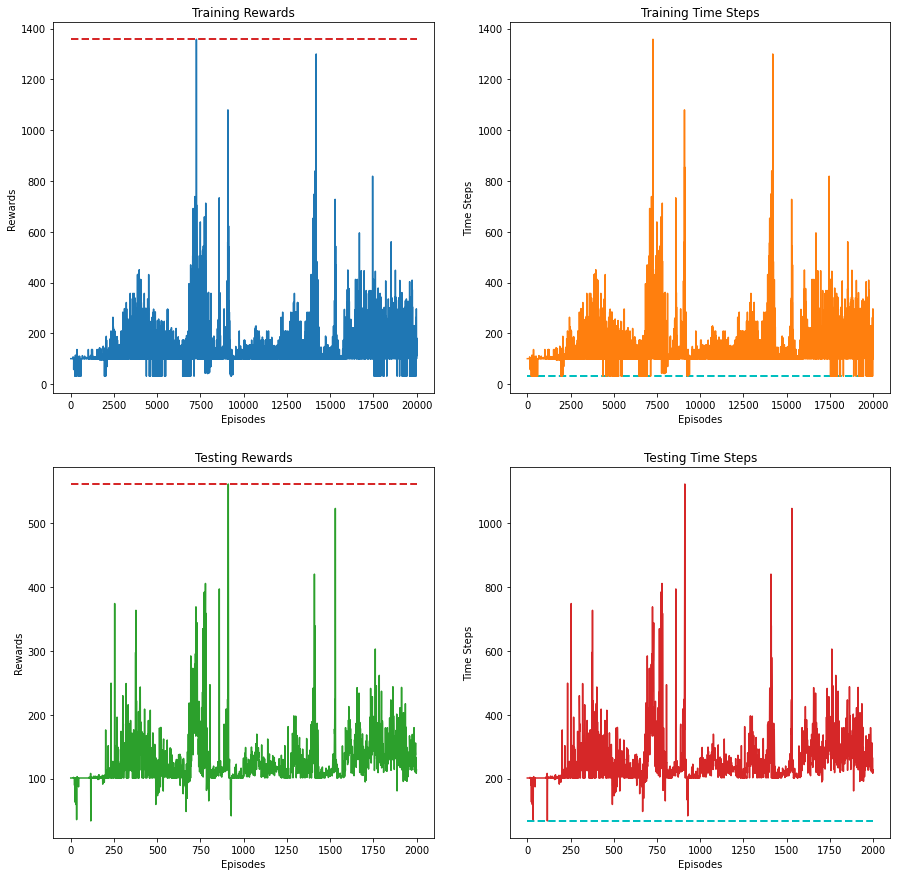

In [ ]:
agent = DQNAgent(num_state=env.observation_space.shape[0], num_action=env.action_space.n, seed=100)
scores = dqn(n_episodes = 20000, eps_start=1.0, eps_end=0.01)

Streaming output truncated to the last 5000 lines.
Episode 15001	Total Rewards: 115.00	Time Steps: 115
Episode 15002	Total Rewards: 112.00	Time Steps: 112
Episode 15003	Total Rewards: 107.00	Time Steps: 107
Episode 15004	Total Rewards: 109.00	Time Steps: 109
Episode 15005	Total Rewards: 114.00	Time Steps: 114
Episode 15006	Total Rewards: 115.00	Time Steps: 115
Episode 15007	Total Rewards: 101.00	Time Steps: 101
Episode 15008	Total Rewards: 137.00	Time Steps: 137
Episode 15009	Total Rewards: 175.00	Time Steps: 175
Episode 15010	Total Rewards: 183.00	Time Steps: 183
Episode 15011	Total Rewards: 151.00	Time Steps: 151
Episode 15012	Total Rewards: 101.00	Time Steps: 101
Episode 15013	Total Rewards: 101.00	Time Steps: 101
Episode 15014	Total Rewards: 265.00	Time Steps: 265
Episode 15015	Total Rewards: 121.00	Time Steps: 121
Episode 15016	Total Rewards: 115.00	Time Steps: 115
Episode 15017	Total Rewards: 116.00	Time Steps: 116
Episode 15018	Total Rewards: 137.00	Time Steps: 137
Episode 15019

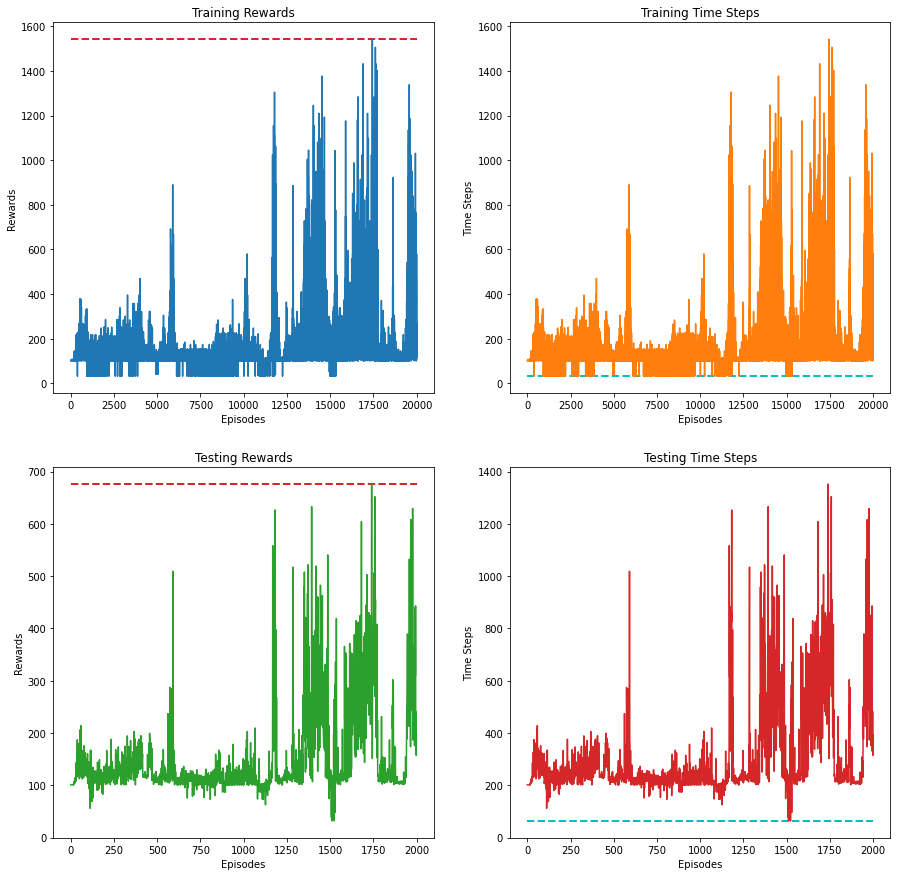

In [ ]:
scores = dqn(n_episodes = 20000, eps_start=0.8, eps_end=0.01)

Episode 1	Total Rewards: 101.00	Time Steps: 101
Episode 2	Total Rewards: 101.00	Time Steps: 101
Episode 3	Total Rewards: 101.00	Time Steps: 101
Episode 4	Total Rewards: 101.00	Time Steps: 101
Episode 5	Total Rewards: 101.00	Time Steps: 101
Episode 6	Total Rewards: 101.00	Time Steps: 101
Episode 7	Total Rewards: 101.00	Time Steps: 101
Episode 8	Total Rewards: 101.00	Time Steps: 101
Episode 9	Total Rewards: 101.00	Time Steps: 101
Episode 10	Total Rewards: 101.00	Time Steps: 101
Episode 11	Total Rewards: 101.00	Time Steps: 101
Episode 12	Total Rewards: 101.00	Time Steps: 101
Episode 13	Total Rewards: 101.00	Time Steps: 101
Episode 14	Total Rewards: 101.00	Time Steps: 101
Episode 15	Total Rewards: 101.00	Time Steps: 101
Episode 16	Total Rewards: 101.00	Time Steps: 101
Episode 17	Total Rewards: 101.00	Time Steps: 101
Episode 18	Total Rewards: 101.00	Time Steps: 101
Episode 19	Total Rewards: 101.00	Time Steps: 101
Episode 20	Total Rewards: 101.00	Time Steps: 101
Episode 21	Total Rewards: 101

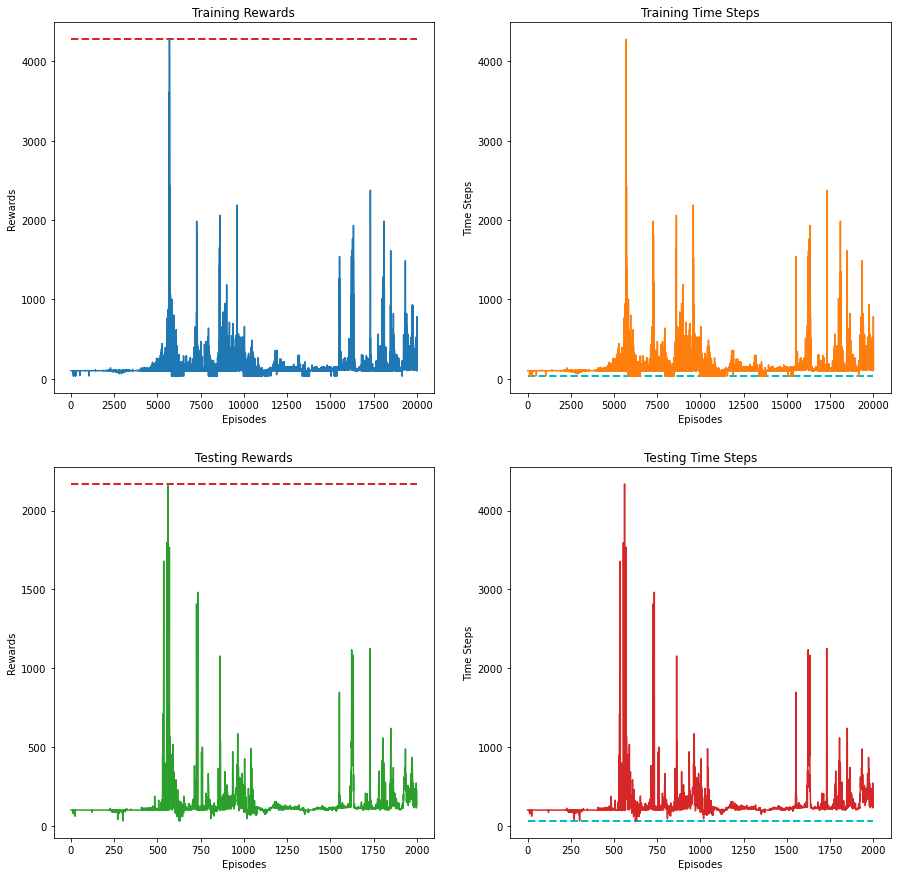

In [ ]:
scores = dqn(n_episodes = 20000, eps_start=0.5, eps_end=0.001)

Episode 1	Total Rewards: 101.00	Time Steps: 101
Episode 2	Total Rewards: 225.00	Time Steps: 225
Episode 3	Total Rewards: 231.00	Time Steps: 231
Episode 4	Total Rewards: 121.00	Time Steps: 121
Episode 5	Total Rewards: 190.00	Time Steps: 190
Episode 6	Total Rewards: 156.00	Time Steps: 156
Episode 7	Total Rewards: 264.00	Time Steps: 264
Episode 8	Total Rewards: 110.00	Time Steps: 110
Episode 9	Total Rewards: 153.00	Time Steps: 153
Episode 10	Total Rewards: 156.00	Time Steps: 156
Episode 11	Total Rewards: 114.00	Time Steps: 114
Episode 12	Total Rewards: 118.00	Time Steps: 118
Episode 13	Total Rewards: 147.00	Time Steps: 147
Episode 14	Total Rewards: 228.00	Time Steps: 228
Episode 15	Total Rewards: 195.00	Time Steps: 195
Episode 16	Total Rewards: 194.00	Time Steps: 194
Episode 17	Total Rewards: 152.00	Time Steps: 152
Episode 18	Total Rewards: 229.00	Time Steps: 229
Episode 19	Total Rewards: 229.00	Time Steps: 229
Episode 20	Total Rewards: 153.00	Time Steps: 153
Episode 21	Total Rewards: 137

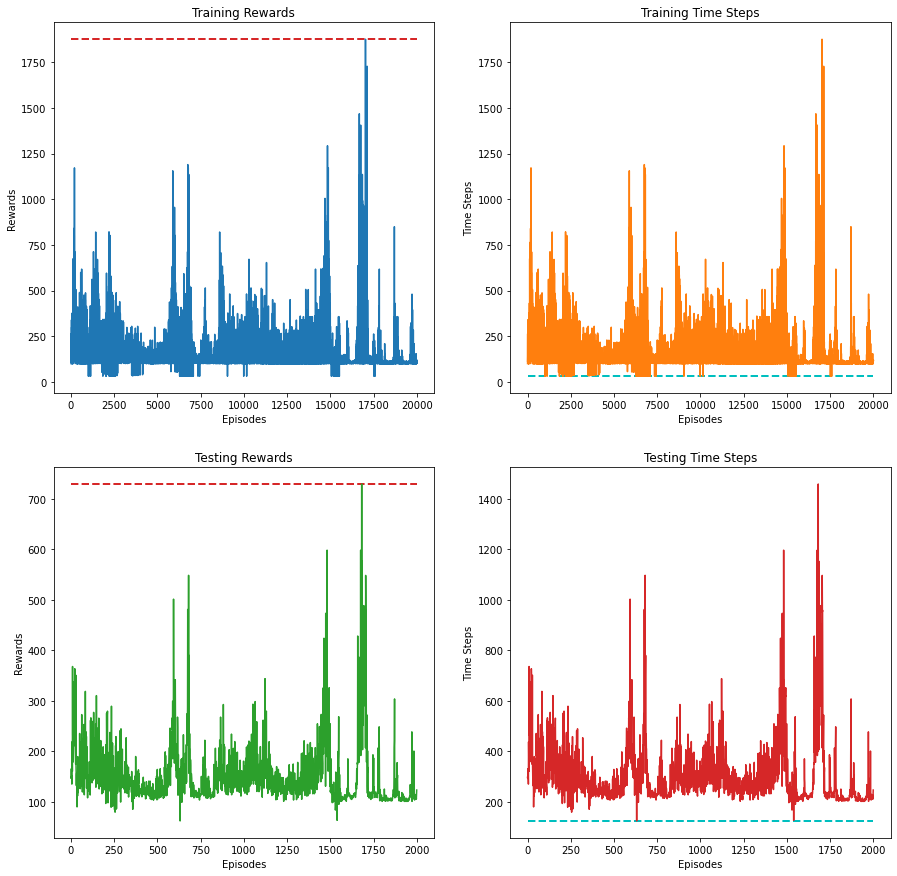

In [ ]:
scores = dqn(n_episodes = 20000, eps_start=1, eps_end=0.01, eps_decay=0.0005)